In [1]:
'''
https://tiensu.github.io/blog/67_audio_deep_learning_part_1
https://tiensu.github.io/blog/68_audio_deep_learning_part_2
https://tiensu.github.io/blog/69_audio_deep_learning_part_3
https://tiensu.github.io/blog/70_audio_deep_learning_part_4
https://tiensu.github.io/blog/71_audio_deep_learning_part_5


https://huggingface-co.translate.goog/learn/audio-course/chapter4/classification_models?_x_tr_sl=en&_x_tr_tl=vi&_x_tr_hl=vi&_x_tr_pto=tc

Fine-Tuning ResNet-18 for Audio Classification
https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc


'''

'\nhttps://tiensu.github.io/blog/67_audio_deep_learning_part_1\nhttps://tiensu.github.io/blog/68_audio_deep_learning_part_2\nhttps://tiensu.github.io/blog/69_audio_deep_learning_part_3\nhttps://tiensu.github.io/blog/70_audio_deep_learning_part_4\nhttps://tiensu.github.io/blog/71_audio_deep_learning_part_5\n\n\nhttps://huggingface-co.translate.goog/learn/audio-course/chapter4/classification_models?_x_tr_sl=en&_x_tr_tl=vi&_x_tr_hl=vi&_x_tr_pto=tc\n\nFine-Tuning ResNet-18 for Audio Classification\nhttps://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc\n\n\n'

## **Audio Classification**

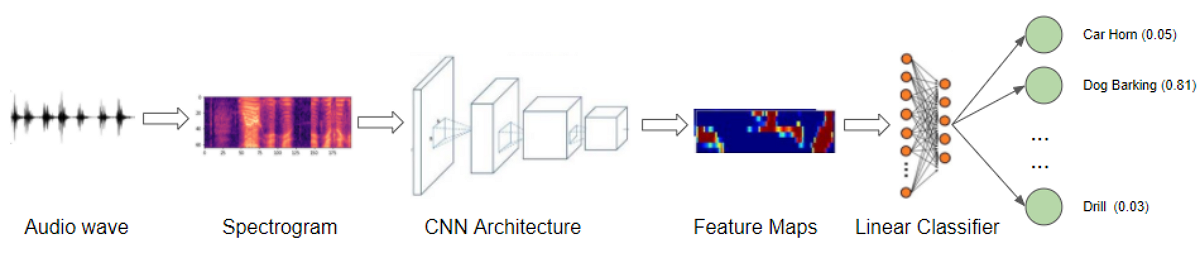

Load Dataset Urban Sound 8K

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'urbansound8k' dataset.
Path to dataset files: /kaggle/input/urbansound8k


In [5]:
import shutil

shutil.move(path, '/content/urbansound8k')
print('Done')

Done


In [6]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import random

In [7]:
# ==================== 1. DATA PREPARATION ====================
print("=== UrbanSound8K Dataset Introduction ===")

data_path = '/content/urbansound8k'
metadata_file = '/content/urbansound8k/UrbanSound8K.csv'
df = pd.read_csv(metadata_file)

# Create relative paths
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

print("Dataset Info:")
print(f"Total samples: {len(df)}")
print(f"Classes: {df['class'].unique()}")
print(f"Folds: {df['fold'].unique()}")
print("\nFirst 5 samples:")
print(df[['slice_file_name', 'class', 'fold']].head())

=== UrbanSound8K Dataset Introduction ===
Dataset Info:
Total samples: 8732
Classes: ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
Folds: [ 5 10  2  6  1  9  7  4  3  8]

First 5 samples:
      slice_file_name             class  fold
0    100032-3-0-0.wav          dog_bark     5
1  100263-2-0-117.wav  children_playing     5
2  100263-2-0-121.wav  children_playing     5
3  100263-2-0-126.wav  children_playing     5
4  100263-2-0-137.wav  children_playing     5


In [8]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,relative_path
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,/fold5/100263-2-0-137.wav
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,/fold7/99812-1-2-0.wav
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,/fold7/99812-1-3-0.wav
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,/fold7/99812-1-4-0.wav
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,/fold7/99812-1-5-0.wav


Preprocessing Data

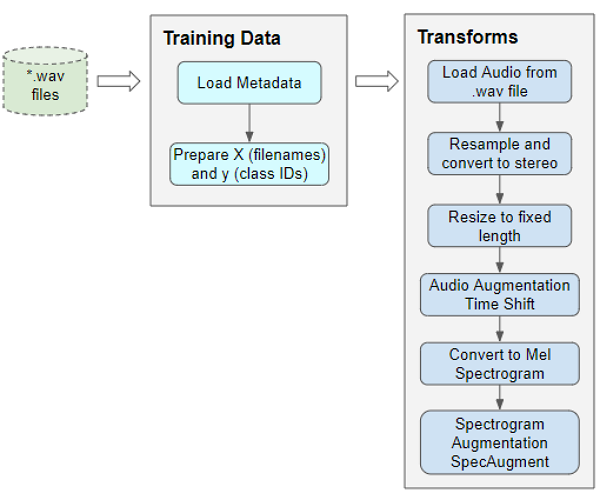

In [9]:
# ==================== 2. AUDIO UTILITIES ====================
class AudioUtil():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        if sig.shape[0] == new_channel:
            return aud
        if new_channel == 1:
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
        return (resig, sr)

    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
        if sr == newsr:
            return aud
        num_channels = sig.shape[0]
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if num_channels > 1:
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return (resig, newsr)

    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if sig_len > max_len:
            sig = sig[:,:max_len]
        elif sig_len < max_len:
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        return (sig, sr)

    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec

    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        return aug_spec

Data Set and DataLoader

In [10]:
# ==================== 3. DATASET CLASS ====================
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, 'relative_path']
        class_id = self.df.loc[idx, 'classID']

        aud = AudioUtil.open(audio_file)
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

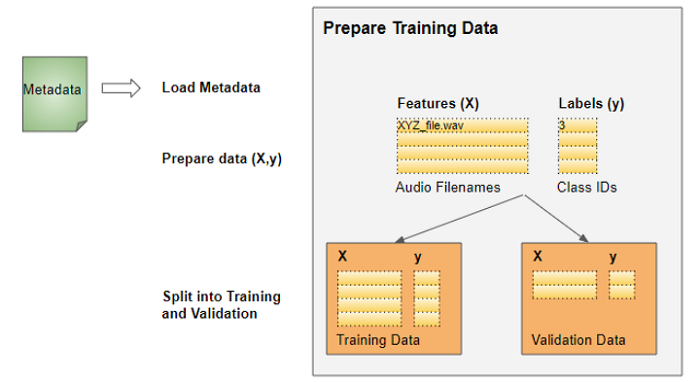

In [11]:
# ==================== 4. CREATE DATASET & DATALOADERS ====================
myds = SoundDS(df, data_path)

# Split dataset
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

print(f"\nDataset split: {num_train} training, {num_val} validation")


Dataset split: 6986 training, 1746 validation


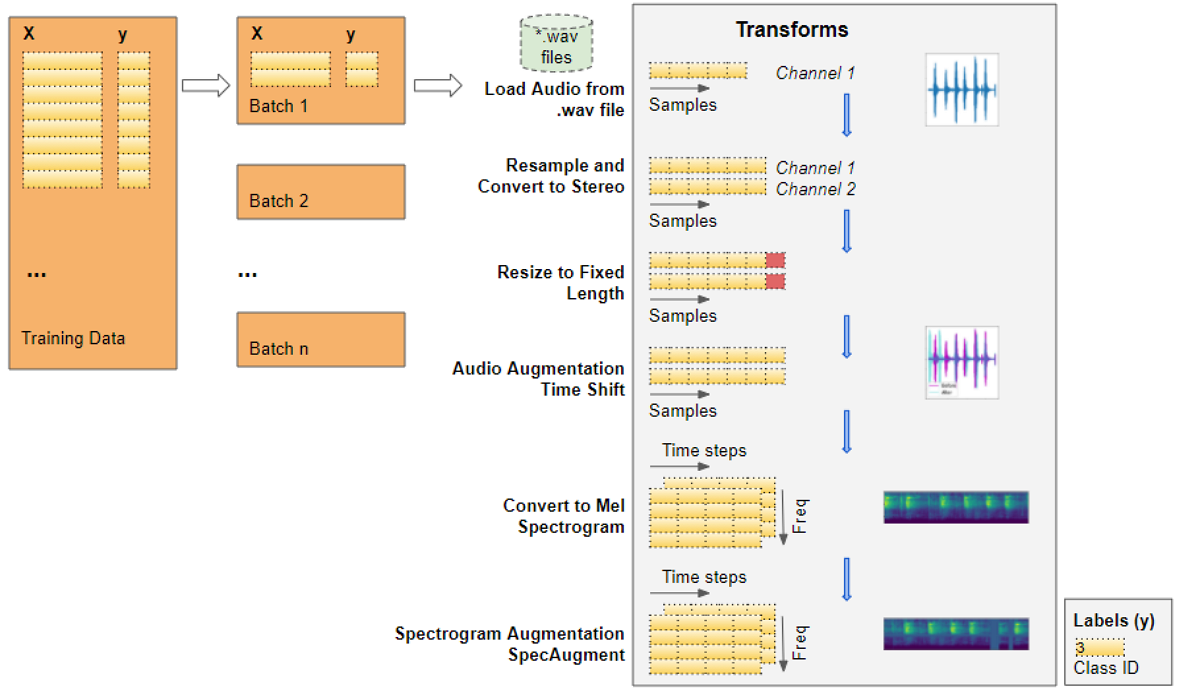


=== Visualizing a Batch ===


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Batch spectrograms shape: torch.Size([16, 2, 64, 344])
Batch labels: tensor([5, 2, 5, 6, 5, 7, 0, 3, 0, 1, 9, 3, 9, 4, 0, 2])
Labels shape: torch.Size([16])


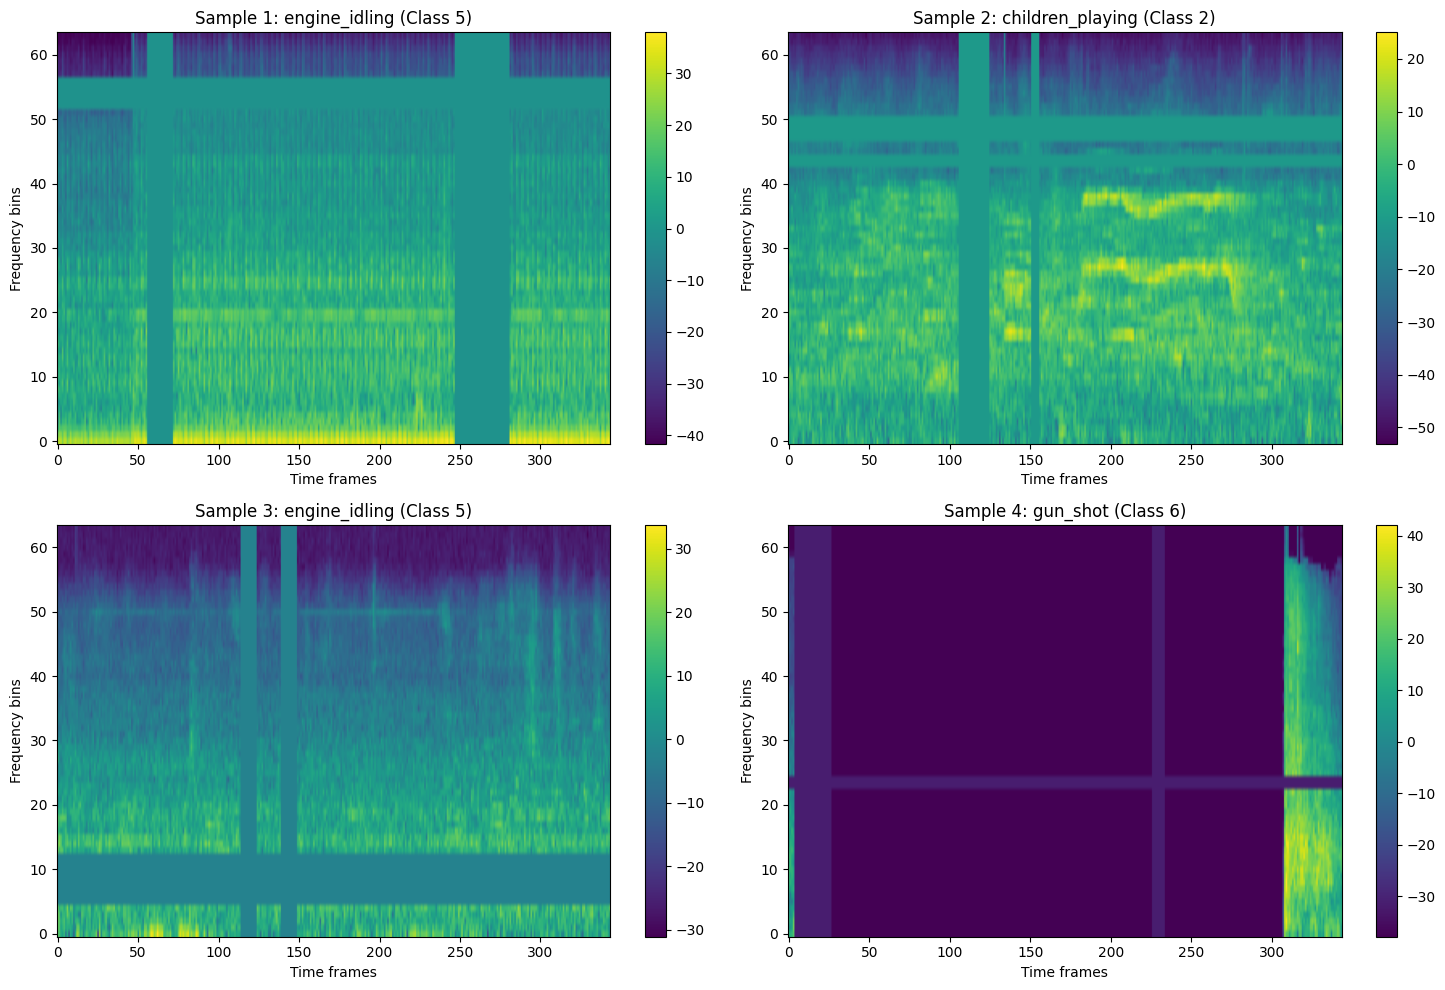

In [12]:
# ==================== 5. VISUALIZE A BATCH ====================
print("\n=== Visualizing a Batch ===")

# Get one batch
batch = next(iter(train_dl))
spectrograms, labels = batch

print(f"Batch spectrograms shape: {spectrograms.shape}")  # [batch, channels, freq, time]
print(f"Batch labels: {labels}")
print(f"Labels shape: {labels.shape}")

# Visualize first 4 spectrograms in the batch
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

class_names = {
    0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing',
    3: 'dog_bark', 4: 'drilling', 5: 'engine_idling',
    6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'
}

for i in range(min(4, len(spectrograms))):
    # Get spectrogram (take first channel if stereo)
    spec = spectrograms[i][0].detach().numpy()  # Shape: [freq, time]

    # Plot spectrogram
    im = axes[i].imshow(spec, origin='lower', aspect='auto', cmap='viridis')
    axes[i].set_title(f'Sample {i+1}: {class_names[labels[i].item()]} (Class {labels[i].item()})')
    axes[i].set_xlabel('Time frames')
    axes[i].set_ylabel('Frequency bins')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

In [13]:
# Show batch statistics
print(f"\nBatch Statistics:")
print(f"Spectrogram range: [{spectrograms.min():.2f}, {spectrograms.max():.2f}]")
print(f"Mean: {spectrograms.mean():.2f}, Std: {spectrograms.std():.2f}")
print(f"Label distribution: {torch.bincount(labels).tolist()}")


Batch Statistics:
Spectrogram range: [-61.17, 42.15]
Mean: -13.12, Std: 20.35
Label distribution: [3, 1, 2, 2, 1, 3, 1, 1, 0, 2]


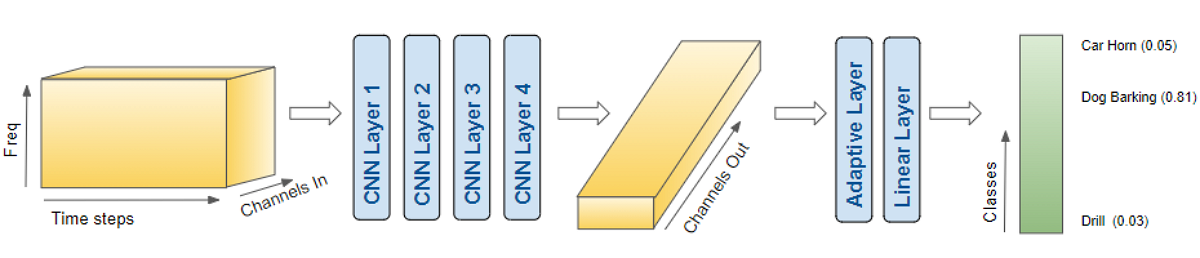

In [14]:
# ==================== 6. MODEL ARCHITECTURE ====================
class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # Convolutional blocks
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

In [15]:
# ==================== 7. MODEL SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Create model - FIXED the model creation
myModel = AudioClassifier()
if torch.cuda.device_count() > 1:
    myModel = nn.DataParallel(myModel)
myModel = myModel.to(device)

print(f"Model on: {next(myModel.parameters()).device}")
print(f"Model architecture:\n{myModel}")


Using device: cuda
Model on: cuda:0
Model architecture:
AudioClassifier(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
  (conv): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)

In [16]:
from tqdm import tqdm

# ==================== 8. TRAINING FUNCTION WITH PROGRESS BAR ====================
def training(model, train_dl, val_dl, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                  steps_per_epoch=len(train_dl),
                                                  epochs=num_epochs,
                                                  anneal_strategy='linear')

    print(f"\n=== Starting Training for {num_epochs} epochs ===")

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Create progress bar for training
        train_pbar = tqdm(train_dl, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for i, data in enumerate(train_pbar):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # Update progress bar
            current_loss = running_loss / (i + 1)
            current_acc = correct_prediction / total_prediction
            train_pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

        # Calculate training metrics
        avg_train_loss = running_loss / len(train_dl)
        train_acc = correct_prediction / total_prediction
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_prediction = 0
        val_total_prediction = 0

        # Create progress bar for validation
        val_pbar = tqdm(val_dl, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for i, data in enumerate(val_pbar):
                inputs, labels = data[0].to(device), data[1].to(device)

                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, prediction = torch.max(outputs, 1)
                val_correct_prediction += (prediction == labels).sum().item()
                val_total_prediction += prediction.shape[0]

                # Update validation progress bar
                current_val_loss = val_running_loss / (i + 1)
                current_val_acc = val_correct_prediction / val_total_prediction
                val_pbar.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.4f}'
                })

        # Calculate validation metrics
        avg_val_loss = val_running_loss / len(val_dl)
        val_acc = val_correct_prediction / val_total_prediction
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print('-' * 50)

    print('Finished Training!')

    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    return model

In [17]:
# ==================== PLOTTING FUNCTION ====================
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
# ==================== 9. INFERENCE FUNCTION ====================
def inference(model, test_dl):
    model.eval()
    correct_prediction = 0
    total_prediction = 0

    print("\n=== Running Inference ===")
    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction / total_prediction
    print(f'Validation Accuracy: {acc:.4f}, Total samples: {total_prediction}')
    return acc


=== Starting Training for 15 epochs ===


Epoch 1/15 [Train]:   0%|          | 0/437 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/p


Epoch 1/15 Summary:
Train Loss: 2.0077, Train Acc: 0.2810
Val Loss: 1.7878, Val Acc: 0.3666
--------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 110/110 [00:46<00:00,  2.38it/s, Loss=1.5618, Acc=0.4519]



Epoch 2/15 Summary:
Train Loss: 1.6899, Train Acc: 0.4204
Val Loss: 1.5618, Val Acc: 0.4519
--------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.48it/s, Loss=1.4455, Acc=0.4845]



Epoch 3/15 Summary:
Train Loss: 1.5107, Train Acc: 0.4771
Val Loss: 1.4455, Val Acc: 0.4845
--------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.45it/s, Loss=1.3099, Acc=0.5389]



Epoch 4/15 Summary:
Train Loss: 1.3456, Train Acc: 0.5348
Val Loss: 1.3099, Val Acc: 0.5389
--------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.49it/s, Loss=1.1941, Acc=0.5876]



Epoch 5/15 Summary:
Train Loss: 1.2075, Train Acc: 0.5883
Val Loss: 1.1941, Val Acc: 0.5876
--------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 110/110 [00:45<00:00,  2.44it/s, Loss=0.9259, Acc=0.6753]



Epoch 6/15 Summary:
Train Loss: 1.0496, Train Acc: 0.6470
Val Loss: 0.9259, Val Acc: 0.6753
--------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.48it/s, Loss=0.8625, Acc=0.6993]



Epoch 7/15 Summary:
Train Loss: 0.9535, Train Acc: 0.6781
Val Loss: 0.8625, Val Acc: 0.6993
--------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 110/110 [00:45<00:00,  2.42it/s, Loss=0.8073, Acc=0.7176]



Epoch 8/15 Summary:
Train Loss: 0.8839, Train Acc: 0.7074
Val Loss: 0.8073, Val Acc: 0.7176
--------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.49it/s, Loss=0.7074, Acc=0.7520]



Epoch 9/15 Summary:
Train Loss: 0.8112, Train Acc: 0.7270
Val Loss: 0.7074, Val Acc: 0.7520
--------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 110/110 [00:45<00:00,  2.40it/s, Loss=0.6653, Acc=0.7646]



Epoch 10/15 Summary:
Train Loss: 0.7466, Train Acc: 0.7557
Val Loss: 0.6653, Val Acc: 0.7646
--------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 110/110 [00:43<00:00,  2.53it/s, Loss=0.7004, Acc=0.7606]



Epoch 11/15 Summary:
Train Loss: 0.7174, Train Acc: 0.7592
Val Loss: 0.7004, Val Acc: 0.7606
--------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 110/110 [00:45<00:00,  2.40it/s, Loss=0.6048, Acc=0.7921]



Epoch 12/15 Summary:
Train Loss: 0.6941, Train Acc: 0.7728
Val Loss: 0.6048, Val Acc: 0.7921
--------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 110/110 [00:44<00:00,  2.48it/s, Loss=0.5983, Acc=0.8018]



Epoch 13/15 Summary:
Train Loss: 0.6525, Train Acc: 0.7853
Val Loss: 0.5983, Val Acc: 0.8018
--------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 110/110 [00:43<00:00,  2.53it/s, Loss=0.5685, Acc=0.8076]



Epoch 14/15 Summary:
Train Loss: 0.6222, Train Acc: 0.7954
Val Loss: 0.5685, Val Acc: 0.8076
--------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 110/110 [00:40<00:00,  2.68it/s, Loss=0.5815, Acc=0.8087]



Epoch 15/15 Summary:
Train Loss: 0.6035, Train Acc: 0.8072
Val Loss: 0.5815, Val Acc: 0.8087
--------------------------------------------------
Finished Training!


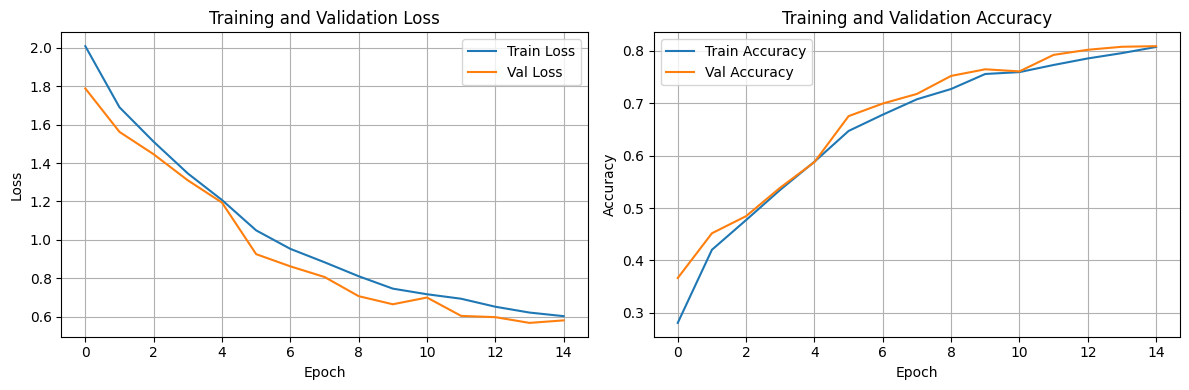

In [19]:
# ==================== 10. RUN TRAINING & EVALUATION ====================
# Train the model
num_epochs = 15
trained_model = training(myModel, train_dl, val_dl, num_epochs)

In [20]:
# Save model
torch.save(trained_model.state_dict(), 'urban_sound_model.pt')
print("Model saved as 'urban_sound_model.pt'")

Model saved as 'urban_sound_model.pt'


Inference

In [21]:
# Run inference
validation_accuracy = inference(trained_model, val_dl)


=== Running Inference ===
Validation Accuracy: 0.8018, Total samples: 1746


In [22]:
print(f"\n=== Summary ===")
print(f"Final Validation Accuracy: {validation_accuracy:.4f}")
print(f"Dataset: UrbanSound8K ({len(df)} samples)")
print(f"Classes: {len(class_names)} sound types")
print("Training completed successfully!")


=== Summary ===
Final Validation Accuracy: 0.8018
Dataset: UrbanSound8K (8732 samples)
Classes: 10 sound types
Training completed successfully!
